# FBS(혈당)

### X변수(기본)
- sex : 1(남자), 2(여자)
- age : 20세 부터 5세 단위
- ht : 5cm단위
- wt : 5kg 단위
- waist : 허리둘레 cm
- bmi 
- absi : 체형지수 => 허리둘레 / (BMI * 2/3) * (ht * 1/2)
- smoking : 1(피우지 않음), 2(피웠다끊음), 3(피우고있음)
- alcohol : 0(마시지않음), 1(마심)

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
import xgboost
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor

## 1. 데이터 불러오기

In [25]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [26]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','식전혈당(공복혈당)']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','fbs']

## 2. 데이터 전처리

### 1) 결측값 제거

In [27]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999062 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999062 non-null  int64  
 1   age      999062 non-null  int64  
 2   ht       999062 non-null  int64  
 3   wt       999062 non-null  int64  
 4   waist    999062 non-null  float64
 5   smoking  999062 non-null  float64
 6   alcohol  999062 non-null  object 
 7   fbs      999062 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


### 2) bmi column 생성

In [28]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)

### 3) absi columns 생성

- 허리둘레 / (BMI * 2/3) * (ht * 1/2)

In [29]:
df['absi'] = (df['waist']*0.393701) / ((df['bmi']**0.6666) * ((df['ht']/100)** 0.5))
df = df.round(decimals = 2)

df.head(10)

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
0,1,8,170,75,90.0,1.0,Y,99.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,106.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,98.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,95.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,101.0,22.04,3.12
5,1,11,165,55,75.0,3.0,Y,99.0,20.20,3.10
6,2,10,150,55,69.0,1.0,N,89.0,24.44,2.63
7,1,8,175,65,84.2,3.0,Y,94.0,21.22,3.27
8,1,12,170,75,84.0,1.0,Y,104.0,25.95,2.89
9,1,9,175,75,82.0,2.0,Y,100.0,24.49,2.89


### 3) alcohol : str -> float형으로 변환

In [30]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [31]:
df.info()

df_o = df.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999062 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999062 non-null  int64  
 1   age      999062 non-null  int64  
 2   ht       999062 non-null  int64  
 3   wt       999062 non-null  int64  
 4   waist    999062 non-null  float64
 5   smoking  999062 non-null  float64
 6   alcohol  999062 non-null  float64
 7   fbs      999062 non-null  float64
 8   bmi      999062 non-null  float64
 9   absi     999062 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


### 4) 이상값 제거

- IQR = Q3 - Q1 
- Q1 -3 * IQR => lower
- Q3 + 3 * IQR => upper 로 설정
- lower보다 작거나 upper보다 큰 값을 이상값으로 간주하고 제거

- 변수마다 lower, upper 값을 확인하고 제거하는 과정을 거치면 다른 변수 lower/upper값에 영향을 줄 수 있음
- 따라서, 변수 각각의 lower, upper 값을 미리 모두 확인 후 각 값에 맞춰 범위 외의 값을 제거해줌.

#### (1) lower / upper 값 구하기

In [32]:
columns = ['bmi','waist', 'absi', 'fbs']

for column in columns:
    
    print('=======', column, '=======')
    
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')
    


======= bmi =======
lower : 8.070000000000004
upper : 39.36 

======= waist =======
lower : 32.999999999999986
upper : 128.9 

======= absi =======
lower : 2.119999999999999
upper : 3.940000000000001 

======= fbs =======
lower : 37.0
upper : 156.0 



#### (2) 이상값 제거 

In [33]:
# bmi
df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55.0)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# fbs
#df.drop(df.loc[(df['fbs']>200.0)|(df['fbs']<37.0)].index, inplace = True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997790 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      997790 non-null  int64  
 1   age      997790 non-null  int64  
 2   ht       997790 non-null  int64  
 3   wt       997790 non-null  int64  
 4   waist    997790 non-null  float64
 5   smoking  997790 non-null  float64
 6   alcohol  997790 non-null  float64
 7   fbs      997790 non-null  float64
 8   bmi      997790 non-null  float64
 9   absi     997790 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.7 MB


In [11]:
scaler2 = StandardScaler()

x_ht = scaler2.fit_transform(df[['ht']])
x_wt = scaler2.fit_transform(df[['wt']])
x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])
x_absi = scaler2.fit_transform(df[['absi']])
x_fbs = scaler2.fit_transform(df[['fbs']])


df_s = df[['sex','age','smoking','alcohol']]

df_s['bmi'] = x_bmi
df_s['waist'] = x_waist
df_s['absi'] = x_absi
df_s['ht'] = x_ht
df_s['wt'] = x_wt
df_s['fbs'] = x_fbs

print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997790 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      997790 non-null  int64  
 1   age      997790 non-null  int64  
 2   smoking  997790 non-null  float64
 3   alcohol  997790 non-null  float64
 4   bmi      997790 non-null  float64
 5   waist    997790 non-null  float64
 6   absi     997790 non-null  float64
 7   ht       997790 non-null  float64
 8   wt       997790 non-null  float64
 9   fbs      997790 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 83.7 MB
None


,sex,age,smoking,alcohol,bmi,waist,absi,ht,wt,fbs
0,1,8,1.0,1.0,0.582129,0.923573,0.339708,0.836459,0.940122,-0.059975
1,1,7,3.0,0.0,0.222148,0.818970,0.239072,1.913899,1.340827,0.228914
2,1,9,1.0,0.0,1.039247,1.028176,0.138436,0.297739,0.940122,-0.101245
3,1,11,1.0,0.0,0.630697,1.028176,0.239072,1.375179,1.340827,-0.225055
4,1,11,1.0,0.0,-0.534953,-0.122457,0.440344,0.297739,-0.261993,0.022565


In [35]:
df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
0,1,8,170,75,90.0,1.0,1.0,99.0,25.95,3.10
1,1,7,180,80,89.0,3.0,0.0,106.0,24.69,3.08
2,1,9,165,75,91.0,1.0,0.0,98.0,27.55,3.06
3,1,11,175,80,91.0,1.0,0.0,95.0,26.12,3.08
4,1,11,165,60,80.0,1.0,0.0,101.0,22.04,3.12


In [15]:
fbs_inverse = scaler2.inverse_transform(df_s[['fbs']])
fbs_inverse

array([[ 99.],
       [106.],
       [ 98.],
       ...,
       [ 90.],
       [ 69.],
       [ 99.]])

# 3. Modeling 

## 1-1) DecisionTreeRegression_원본

In [12]:
## 1. split

X = df_o[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_o['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699343, 9), (299719, 9), (699343,), (299719,))

rmse :  23.142309994390693


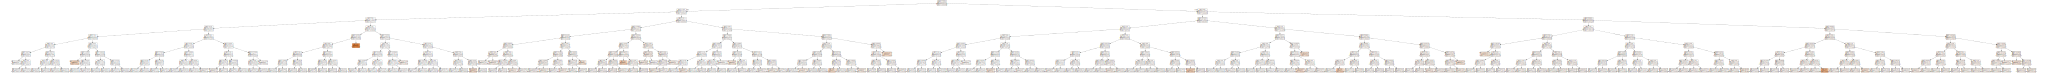

In [13]:
## 2. fit 

dt = DecisionTreeRegressor(random_state = 2045, max_depth = 8  ,min_samples_split = 128)
dt.fit(X_train, y_train)

## 3. Predict

y_hat = dt.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 5. Visualization

graphviz.Source(export_graphviz(dt, filled = True))


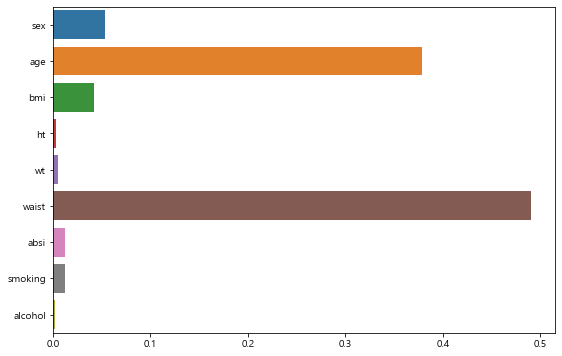

In [14]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(dt.feature_importances_,
           X_train.columns)
plt.show()

In [23]:
## 1. split

X = df[['sex','age','absi','bmi','ht','wt','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

## 2. fit 

dt = DecisionTreeRegressor(random_state = 2045, max_depth = 8  ,min_samples_split = 128)
dt.fit(X_train, y_train)

## 3. Predict

y_hat = dt.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 5. Visualization

# graphviz.Source(export_graphviz(dt, filled = True))


rmse :  16.448900386535495


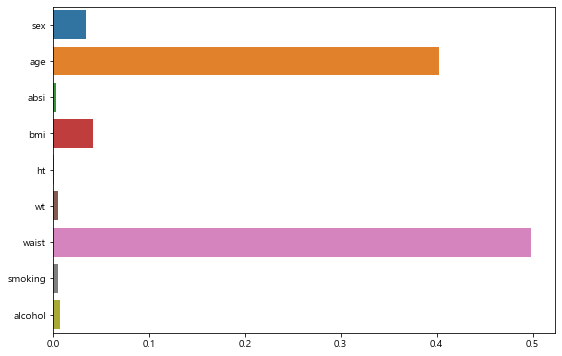

In [24]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(dt.feature_importances_,
           X_train.columns)
plt.show()

- max_depth / min_sample_split 값을 변경해가면서 모델 생성 결과 max_depth:8 일 때 rmse가 13.16으로 가장 적었음
- (min_sample_splie값은 변경해도 변화없음)

- 표준화 및 정규화된 X_train 사용해도 모델 성능에 변화 없음

## 2-1) RandomForest_원본

In [36]:
# standard scaler

X = df_s[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_s['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((698453, 9), (299337, 9), (698453,), (299337,))

In [53]:
%%time

## 2. fit 

rf = RandomForestRegressor(random_state = 2045, max_depth = 10  ,max_features = 4, n_jobs = -1, n_estimators = 200)
rf.fit(X_train, y_train)

Wall time: 25.4 s


RandomForestRegressor(max_depth=10, max_features=4, n_estimators=200, n_jobs=-1,
                      random_state=2045)

In [54]:
## 3. Predict

y_hat = rf.predict(X_test)
df_y_hat = pd.DataFrame(y_hat, columns=['y_hat'])

y_hat_inverse = scaler2.inverse_transform(df_y_hat)

y_hat_inverse

array([[ 94.30900221],
       [ 99.9059896 ],
       [101.97927016],
       ...,
       [101.83994714],
       [ 90.52220779],
       [ 99.21900607]])

In [55]:
df_y_test = y_test.to_frame()

df_y_test.head()
y_test_inverse = scaler2.inverse_transform(df_y_test)

y_test_inverse

array([[ 85.],
       [105.],
       [116.],
       ...,
       [100.],
       [ 79.],
       [100.]])

In [56]:
## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_hat_inverse))

print('rmse : ', rmse)

rmse :  23.14757505788064


In [28]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [26]:
%%time

## 2. fit 

rf = RandomForestRegressor(random_state = 2045, max_depth = 10  ,max_features = 4, n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)

## 3. Predict

y_hat = rf.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  16.418029390101704
Wall time: 12.6 s


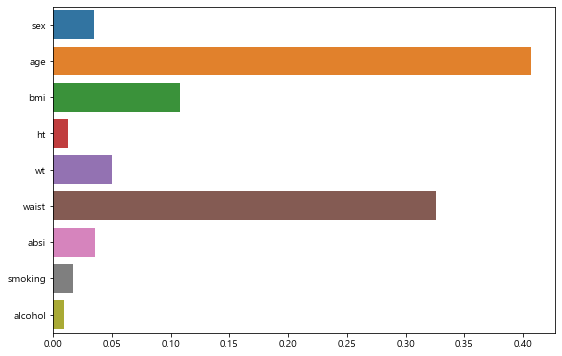

In [27]:
## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(rf.feature_importances_,
           X_train.columns)
plt.show()

## 3-1) GradientBoostingRegressor_원본

rmse :  16.412992133408125


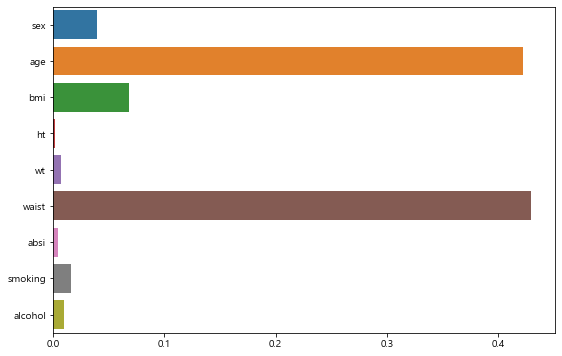

Wall time: 8min 25s


In [29]:
%%time

## 2. fit 

gb = GradientBoostingRegressor(random_state = 2045, n_estimators = 1000, learning_rate = 0.03)
gb.fit(X_train, y_train)

## 3. Predict

y_hat = gb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(gb.feature_importances_,
           X_train.columns)
plt.show()


## 4-1) XGBRegressor_gbtree

rmse :  16.44185269825506
Wall time: 3min 53s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

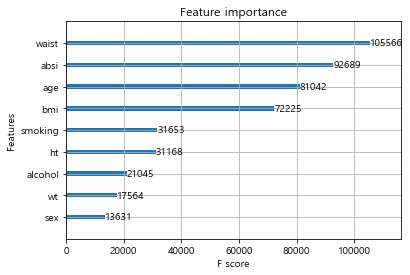

In [30]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045, 
                    n_estimators = 1000, 
                    learning_rate = 0.01,
                   max_depth = 10)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

xgboost.plot_importance(xgb)


## 4-2) XGBRegressor_gblinear

In [31]:
## 1. split

X = df[['sex','age','ht','wt','waist','bmi','absi','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [32]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045,
                   booster = 'gblinear',
                    n_estimators = 2000, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  16.49603054178875
Wall time: 31.6 s


<AxesSubplot:>

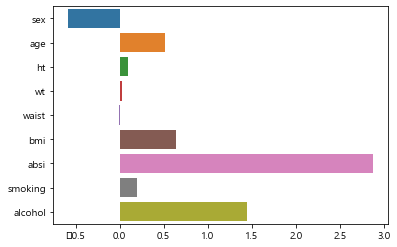

In [31]:
coef = pd.Series(xgb.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

In [34]:
## 1. split

X = df[['sex','age','bmi','ht','wt','absi','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [33]:
%%time

## 2. fit 

xgb = XGBRegressor(random_state = 2045,
                   booster = 'gblinear',
                    n_estimators = 2000, 
                    learning_rate = 0.2)
xgb.fit(X_train, y_train)

## 3. Predict

y_hat = xgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  9.194985760696827
Wall time: 29.8 s


<AxesSubplot:>

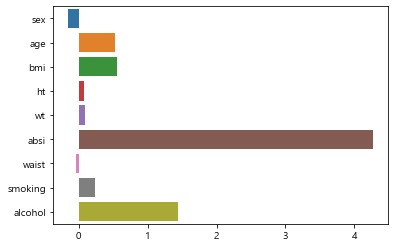

In [173]:
coef = pd.Series(xgb.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

## 5-1) LGBMRegressor

In [69]:
X1 = df[['sex','age','wt','ht','waist','bmi','absi','smoking','alcohol']] #기본
X2 = df[['sex','age','wt','ht','waist','absi','smoking','alcohol']] # bmi 제거
X3 = df[['sex','age','wt','ht','waist','bmi','smoking','alcohol']] # absi 제거
X4 = df[['sex','age','wt','ht','waist','smoking','alcohol']] # bmi, absi 제거
X5 = df[['sex','age','wt','waist','bmi','absi','smoking','alcohol']] # ht 제거
X6 = df[['sex','age','ht','waist','bmi','absi','smoking','alcohol']] # wt 제거
X7 = df[['sex','age','waist','bmi','absi','smoking','alcohol']] # ht, wt 제거
X8 = df[['sex','age','wt','ht','bmi','absi','smoking','alcohol']] # waist 제거

rmse :  16.4162710003583
rmse :  16.41624573048853
rmse :  16.415010219228623
rmse :  16.415455263308342
rmse :  16.416613777014923
rmse :  16.416810621338037
rmse :  16.418219728477933
rmse :  16.41761477051315


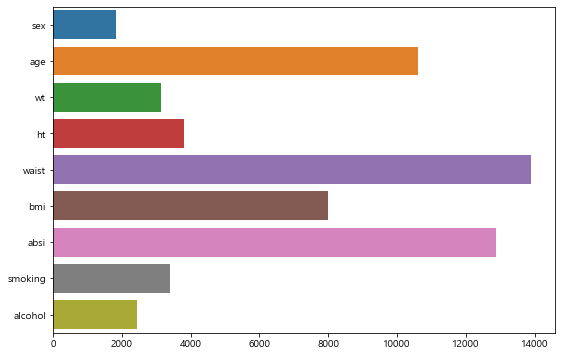

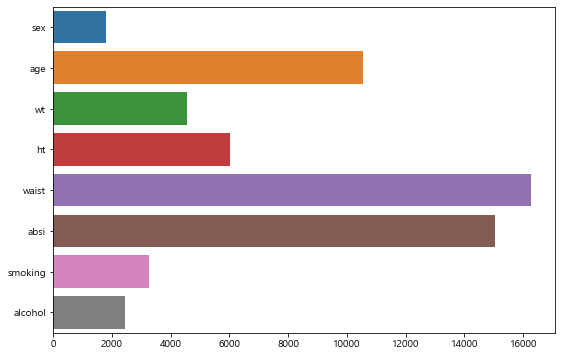

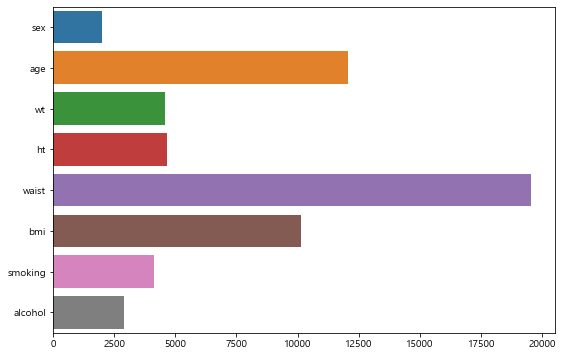

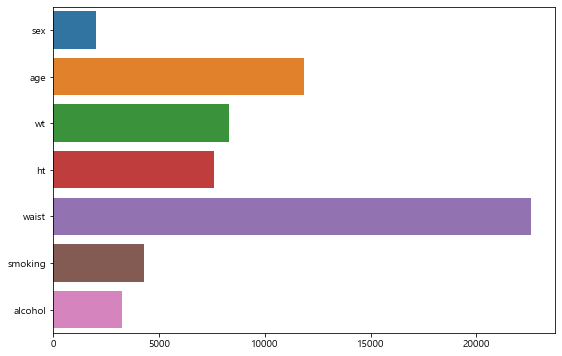

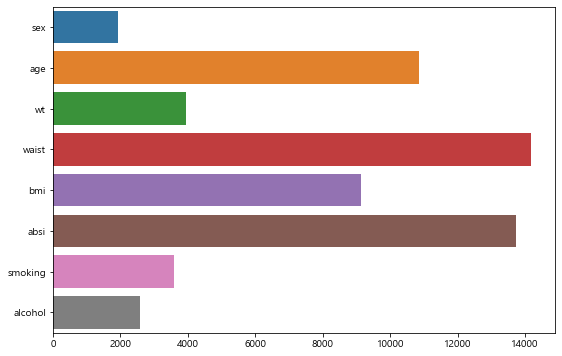

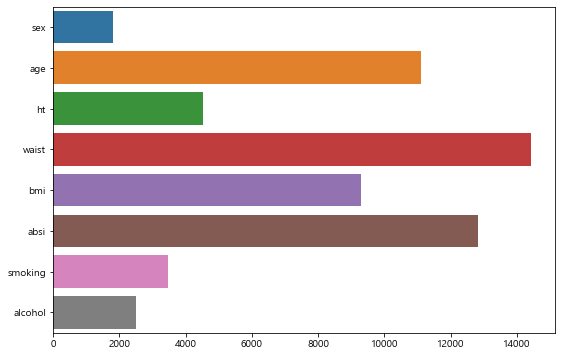

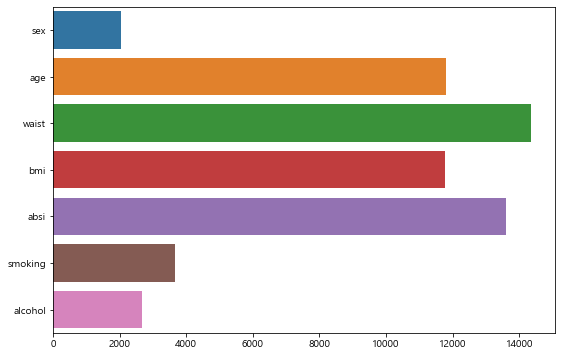

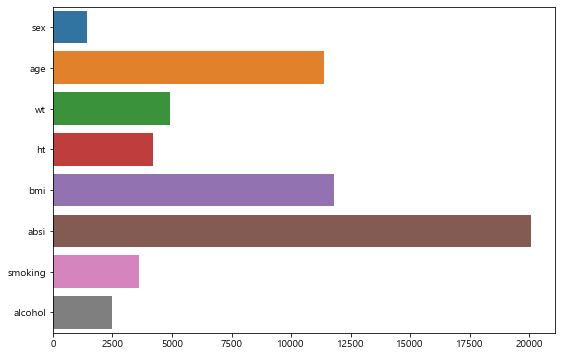

In [70]:
# split
Xs = [X1, X2, X3, X4, X5, X6, X7, X8]

y = df['fbs']

for i, X in enumerate(Xs):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)
    
    ## 2. fit 

    lgb = LGBMRegressor(random_state = 2045,
                        n_estimators = 2000, 
                        learning_rate = 0.01,
                      max_depth = 12)
    lgb.fit(X_train, y_train)

    ## 3. Predict

    y_hat = lgb.predict(X_test)

    ## 4. Root MSE 

    rmse = np.sqrt(mean_squared_error(y_test, y_hat))

    print('rmse : ', rmse)

    ## 6. Feature Importance

    plt.figure(figsize = (9,6))
    sns.barplot(lgb.feature_importances_,
               X_train.columns)
    name = 'LGBMRegressor_FeatureImportance_'+str(i)+'.png'
    plt.savefig(name)

In [66]:
## 1. split

X = df[['sex','age','wt','bmi','waist','ht','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 8), (296153, 8), (691023,), (296153,))

rmse :  16.41501019330447


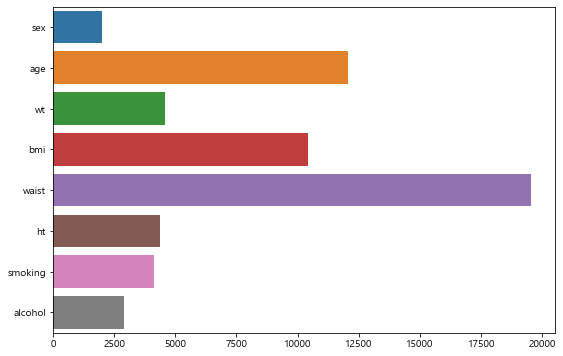

Wall time: 22.5 s


In [67]:
%%time

## 2. fit 

lgb = LGBMRegressor(random_state = 2045,
                    n_estimators = 2000, 
                    learning_rate = 0.01,
                  max_depth = 12)
lgb.fit(X_train, y_train)

## 3. Predict

y_hat = lgb.predict(X_test)

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

## 6. Feature Importance

plt.figure(figsize = (9,6))
sns.barplot(lgb.feature_importances_,
           X_train.columns)
plt.show()


## 6) MLPregressor

In [64]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [65]:
%%time 

## 2. model define & fit

mlp = MLPRegressor(hidden_layer_sizes = (64,64), activation = 'relu', random_state = 2045,
                  max_iter = 2000)
mlp.fit(X_train, y_train)

## 3. predicition

y_hat = mlp.predict(X_test)

## 4. RMSE, R2 score

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  16.423918699517046
Wall time: 7min 56s


In [177]:
mlp.coefs_

[array([[-1.71449625e-002, -4.70669360e-315,  4.64051200e-315,
         -2.62643718e-315,  3.97713584e-315, -4.57210092e-315,
         -2.79595598e-315, -7.46768811e-317, -9.85643271e-316,
         -1.00576959e-315, -3.12746854e-315,  3.56150822e-001,
         -1.83178926e+000, -1.80785157e+000, -1.10959777e-315,
         -1.39476380e-315, -9.54567217e-003, -1.09515725e-315,
          2.50345062e-315,  1.16630228e-001,  4.10334098e-316,
         -3.26070185e-315,  3.75144429e-315,  3.62548964e-315,
         -2.78716480e-315,  3.80485791e-315, -2.76744043e+000,
         -1.73917008e+000, -2.91464151e-315,  3.78122318e+000,
          1.65885576e+000, -2.17672615e-315,  6.65792800e-316,
          4.41274451e-315,  3.52136959e-001, -1.31466872e+000,
         -2.61956605e-315, -2.94100456e-315, -4.81348706e+000,
         -2.80735948e-315, -2.83728457e-315, -7.09771406e-001,
          3.27781455e-316, -1.12491273e-315, -3.00957052e-315,
          1.41650786e-315, -4.66340462e-315, -7.7303266